In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
from scipy.stats import norm
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import sys
sys.path.append('../src')
from models import open_pickle

In [3]:
we_model_load = KeyedVectors.load('../data/interim/glove_840_norm', mmap='r')

'we_model_name = "sg_dim300_min100_win5"\nwe_vector_size = 300\nwe_model_dir = \'../data/external/wiki-english/wiki-english-20171001/%s\' % we_model_name\n\nwe_model = Word2Vec.load(we_model_dir+\'/model.gensim\')\nprint (\'loading done!\')\n'

In [4]:
errors_dict = defaultdict(dict)
p_values_dict = defaultdict(dict)

In [26]:
RESULTS_FILEPATH = '../data/interim/glove_840B_association_metric_exps.pickle'
EXPERIMENT_DEFINITION_FILEPATH = '../data/interim/glove_840B_experiment_definitions.pickle'
SIGTEST_IMAGE_FILEPATH = '../reports/figures/glove_840B_sigtest_intervals.png'
SIGTEST_HORIZONTAL_IMAGE_FILEPATH = '../reports/figures/glove_840B_sigtest_intervals_horizontal.png'
'''RESULTS_FILEPATH = '../data/interim/association_metric_exps.pickle'
EXPERIMENT_DEFINITION_FILEPATH = '../data/interim/experiment_definitions.pickle'
SIGTEST_IMAGE_FILEPATH = '../reports/figures/sigtest_intervals.png'
SIGTEST_HORIZONTAL_IMAGE_FILEPATH = '../reports/figures/sigtest_intervals_horizontal.png'
'''

exp_def_dict = open_pickle(EXPERIMENT_DEFINITION_FILEPATH)
results_dict = open_pickle(RESULTS_FILEPATH)

In [9]:
def get_error(dist, interval_size):
    '''Interval size should be 0<x<1'''
    loc = np.mean(dist)
    scale = np.std(dist, ddof=1)
    err = loc - norm.ppf((1-interval_size)/2, loc=loc, scale=scale)
    return err

In [10]:
def get_p_value(dist, test_statistic):
    loc = np.mean(dist)
    scale = np.std(dist, ddof=1)
    return norm.cdf(test_statistic, loc=loc, scale=scale)

In [11]:
def add_axes_obj_labels(ax, test_num):
    X_AXIS_FONT_SIZE = 12
    Y_AXIS_FONT_SIZE = 15
    test_descriptions = {1: '$s(X_i, Y_i, A, B)$',
                         2: '$s(X, Y_i, A, B)$',
                         3: '$s(X_i, Y, A, B)$'}
    ax.set_xlabel(f'SigTest {test_num}: {test_descriptions[test_num]} \n left=bias towards B, right=bias towards A',
                 fontsize=X_AXIS_FONT_SIZE)
    ax.set_ylabel(f'Experiment Number', fontsize=Y_AXIS_FONT_SIZE)

In [12]:
def annotate_points(ax, txt_array, x_array, y):
    POINT_FONT_SIZE = 10
    NUM_DECIMALS = 3
    for i in range(10):
        ax.annotate(np.round(txt_array[i], NUM_DECIMALS), (x_array[i], y[i]), fontsize=POINT_FONT_SIZE)

   exp_num sample_num  result_value
0        1          0      0.005327
1        2          0      0.005327
2        3          0      0.005075
3        4          0      0.004800
4        5          0     -0.019100
(100000, 3)
Rendering for Test 1...
   exp_num sample_num  result_value
0        1          0      0.033191
1        2          0      0.037452
2        3          0      0.019209
3        4          0      0.013078
4        5          0      0.011247
(100000, 3)
Rendering for Test 2...
   exp_num sample_num  result_value
0        1          0      0.021661
1        2          0      0.027581
2        3          0     -0.000098
3        4          0     -0.002345
4        5          0     -0.021358
(100000, 3)
Rendering for Test 3...


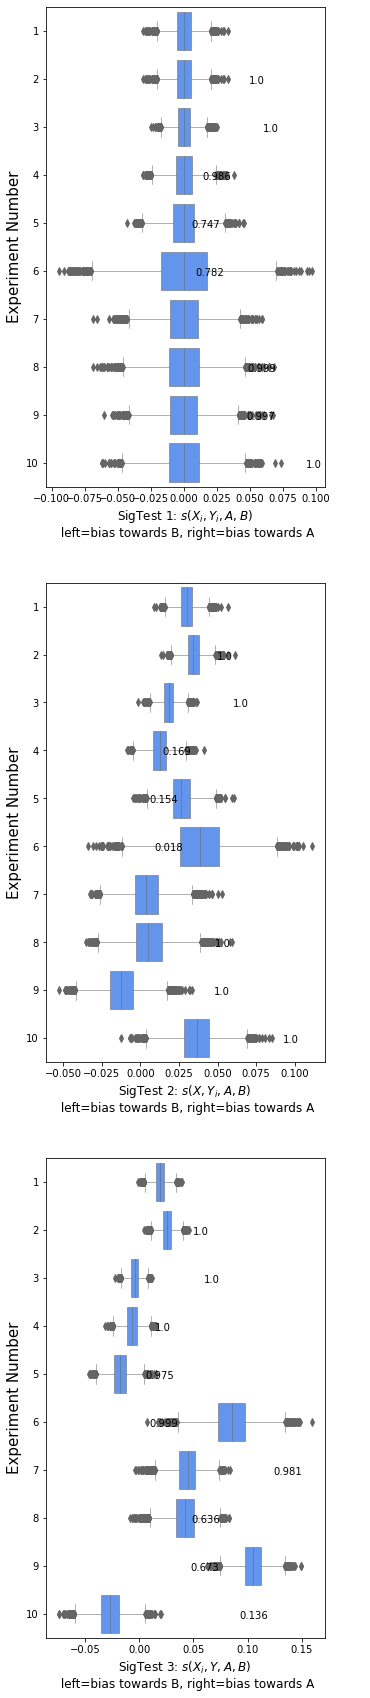

In [35]:
# Seaborn Boxplot
fig, axs = plt.subplots(3,1, figsize=(5,30))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_ANNOTATION_OFFSET = 0.1
exp_nums = [i for i in range(1,11)]

for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    y = [i for i in range(1,11)]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.8) for exp_num in exp_nums]
    errors_99 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.9) for exp_num in exp_nums]
    errors_999 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.999) for exp_num in exp_nums]
    
    #ax.errorbar(means, y, xerr=errors_95, fmt='|', color='r', capsize=5, label='95% CI')
    #ax.errorbar(means, y, xerr=errors_99, fmt='|', color='g', capsize=5, label='99% CI')
    #ax.errorbar(means, y, xerr=errors_999, fmt='|', color='k', capsize=5, label='999% CI')
    #ax.scatter(test_stats, y)
    dists = np.array([results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums])
    df = pd.DataFrame(dists)
    df['exp_num'] = df.index.values
    df['exp_num'] = df['exp_num'] + 1
    df = df.melt(id_vars=['exp_num'], var_name='sample_num', value_name='result_value')
    print(df.head())
    print(df.shape)
    quants = [[0.025, 0.05, 0.1, 0.9, 0.999, 0.975] for i in range(10)]
    #ax.violinplot(dists, vert=False, quantiles=quants)
    #df = pd.DataFrame(, y, columns=['dists','y'])
    print(f'Rendering for Test {test_num}...')
    ax = sns.boxplot(x='result_value', y='exp_num', data=df, ax=ax, orient='h',
                      saturation=1.2, color='cornflowerblue', linewidth=0.5)
    
    #ax.set_xlim(X_AXIS_LIMITS)
    #fig.suptitle('Sig Tests', fontsize=20)
    #fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)
    
#ax = sns.violinplot(x="day", y="total_bill", data=tips)
#g = sns.violinplot(x='result_value', y='exp_num', orient='h', data=df)


   exp_num sample_num  result_value
0        1          0     -0.005517
1        2          0     -0.008217
2        3          0      0.005673
3        4          0     -0.005467
4        5          0      0.011757
(100000, 3)
Rendering for Test 1...
   exp_num sample_num  result_value
0        1          0      0.061305
1        2          0      0.066657
2        3          0      0.066017
3        4          0      0.035225
4        5          0      0.120707
(100000, 3)
Rendering for Test 2...
   exp_num sample_num  result_value
0        1          0      0.024056
1        2          0      0.017446
2        3          0     -0.009695
3        4          0     -0.004288
4        5          0     -0.050565
(100000, 3)
Rendering for Test 3...


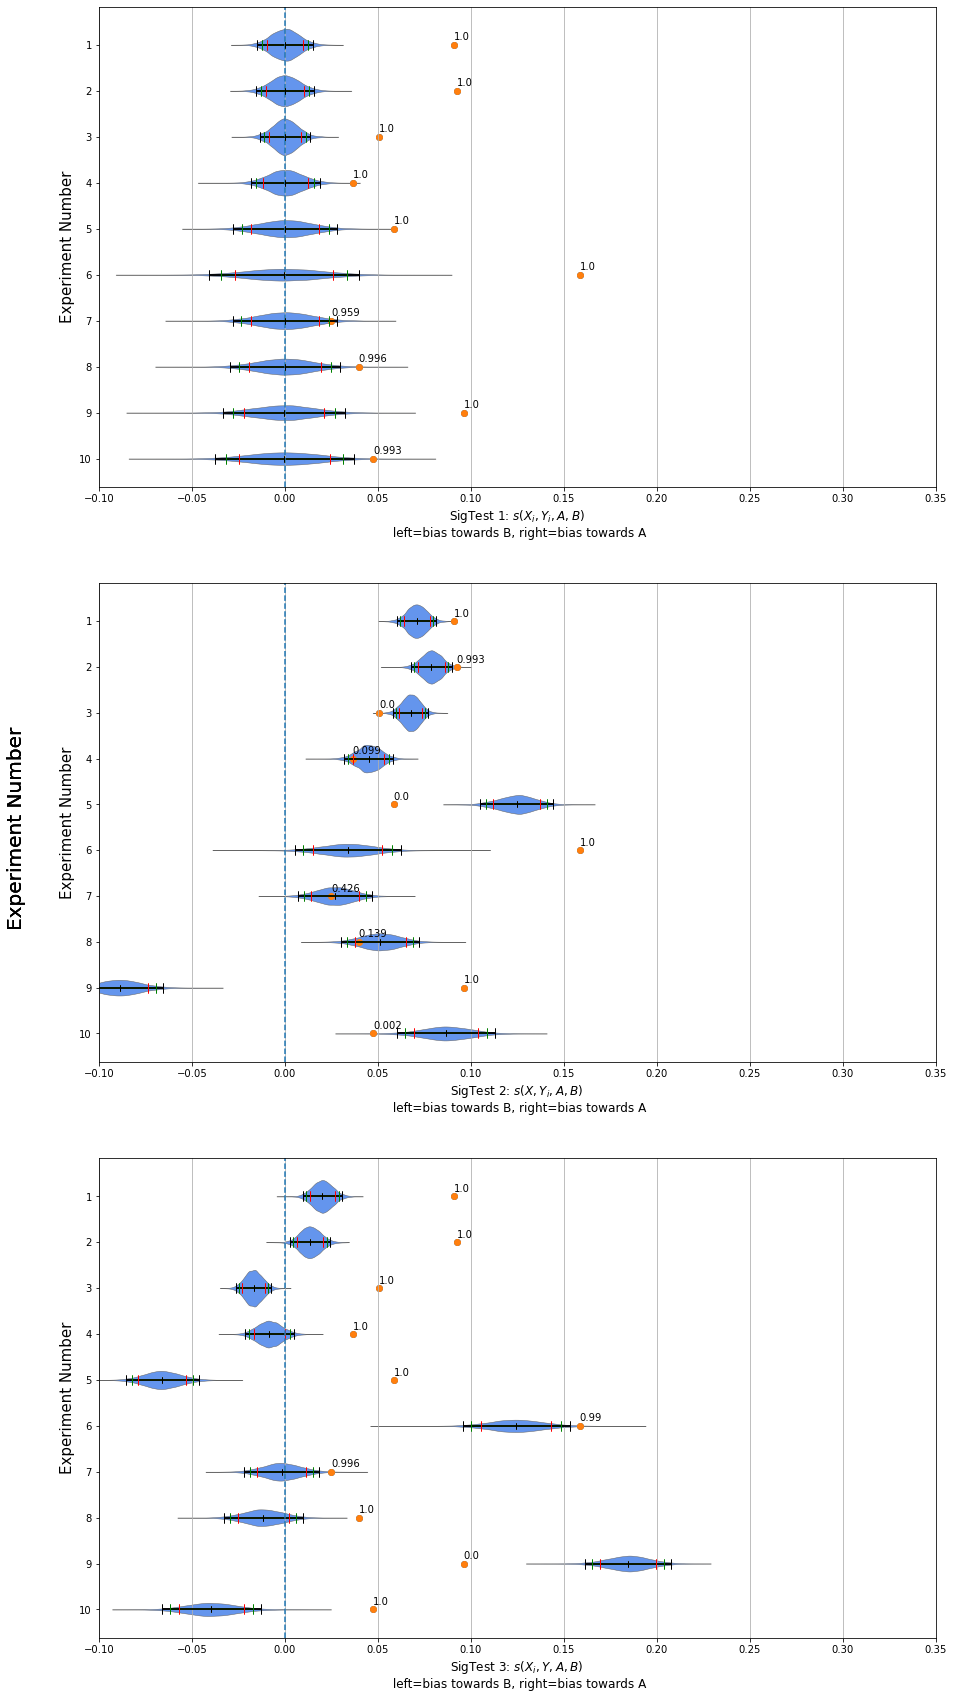

In [21]:
# Seaborn Violinplot
fig, axs = plt.subplots(3,1, figsize=(15,30))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_AXIS_LIMITS = [11,0]
Y_ANNOTATION_OFFSET = -0.1
exp_nums = [i for i in range(1,11)]


for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    y = [i-1 for i in range(1,11)]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.8) for exp_num in exp_nums]
    errors_99 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.9) for exp_num in exp_nums]
    errors_999 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.999) for exp_num in exp_nums]
    
    ax.errorbar(means, y, xerr=errors_95, fmt='|', color='r', capsize=5, label='95% CI')
    ax.errorbar(means, y, xerr=errors_99, fmt='|', color='g', capsize=5, label='99% CI')
    ax.errorbar(means, y, xerr=errors_999, fmt='|', color='k', capsize=5, label='999% CI')
    ax.scatter(test_stats, y)
    
    dists = np.array([results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums])
    df = pd.DataFrame(dists)
    df['exp_num'] = df.index.values
    df['exp_num'] = df['exp_num'] + 1
    df = df.melt(id_vars=['exp_num'], var_name='sample_num', value_name='result_value')
    print(df.head())
    print(df.shape)
    quants = [[0.025, 0.05, 0.1, 0.9, 0.999, 0.975] for i in range(10)]
    #ax.violinplot(dists, vert=False, quantiles=quants)
    #df = pd.DataFrame(, y, columns=['dists','y'])
    print(f'Rendering for Test {test_num}...')
    ax = sns.violinplot(x='result_value', y='exp_num', data=df, ax=ax, orient='h',
                      saturation=1.2, color='cornflowerblue', inner=None, linewidth=0.5)
    ax.errorbar(means, y, xerr=errors_95, fmt='|', color='r', capsize=5, label='95% CI')
    ax.errorbar(means, y, xerr=errors_99, fmt='|', color='g', capsize=5, label='99% CI')
    ax.errorbar(means, y, xerr=errors_999, fmt='|', color='k', capsize=5, label='999% CI')
    ax.scatter(test_stats, y)
    
    ax.axvline(0, label='zero-line', linestyle='--')
    ax.xaxis.grid()
    
    ax.set_xlim(X_AXIS_LIMITS)
    #fig.suptitle('Sig Tests', fontsize=20)
    fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)
    
#ax = sns.violinplot(x="day", y="total_bill", data=tips)
#g = sns.violinplot(x='result_value', y='exp_num', orient='h', data=df)


### Results dictionaries are calculated in this cell

Means: [6.874919e-05, -1.836285e-05, 1.9099564e-07, 0.0001263756, 9.111843e-05, -0.0003859098, 1.40414295e-05, -5.53638e-05, -0.0005714454, -0.0002999305]
Means: [0.07081081, 0.07870139, 0.06757939, 0.044936627, 0.12450166, 0.033672754, 0.0267449, 0.05111917, -0.08884807, 0.08658422]
Means: [0.020134829, 0.013599799, -0.01692985, -0.00840633, -0.06602604, 0.124313794, -0.0018655381, -0.011654479, 0.18435752, -0.0395846]


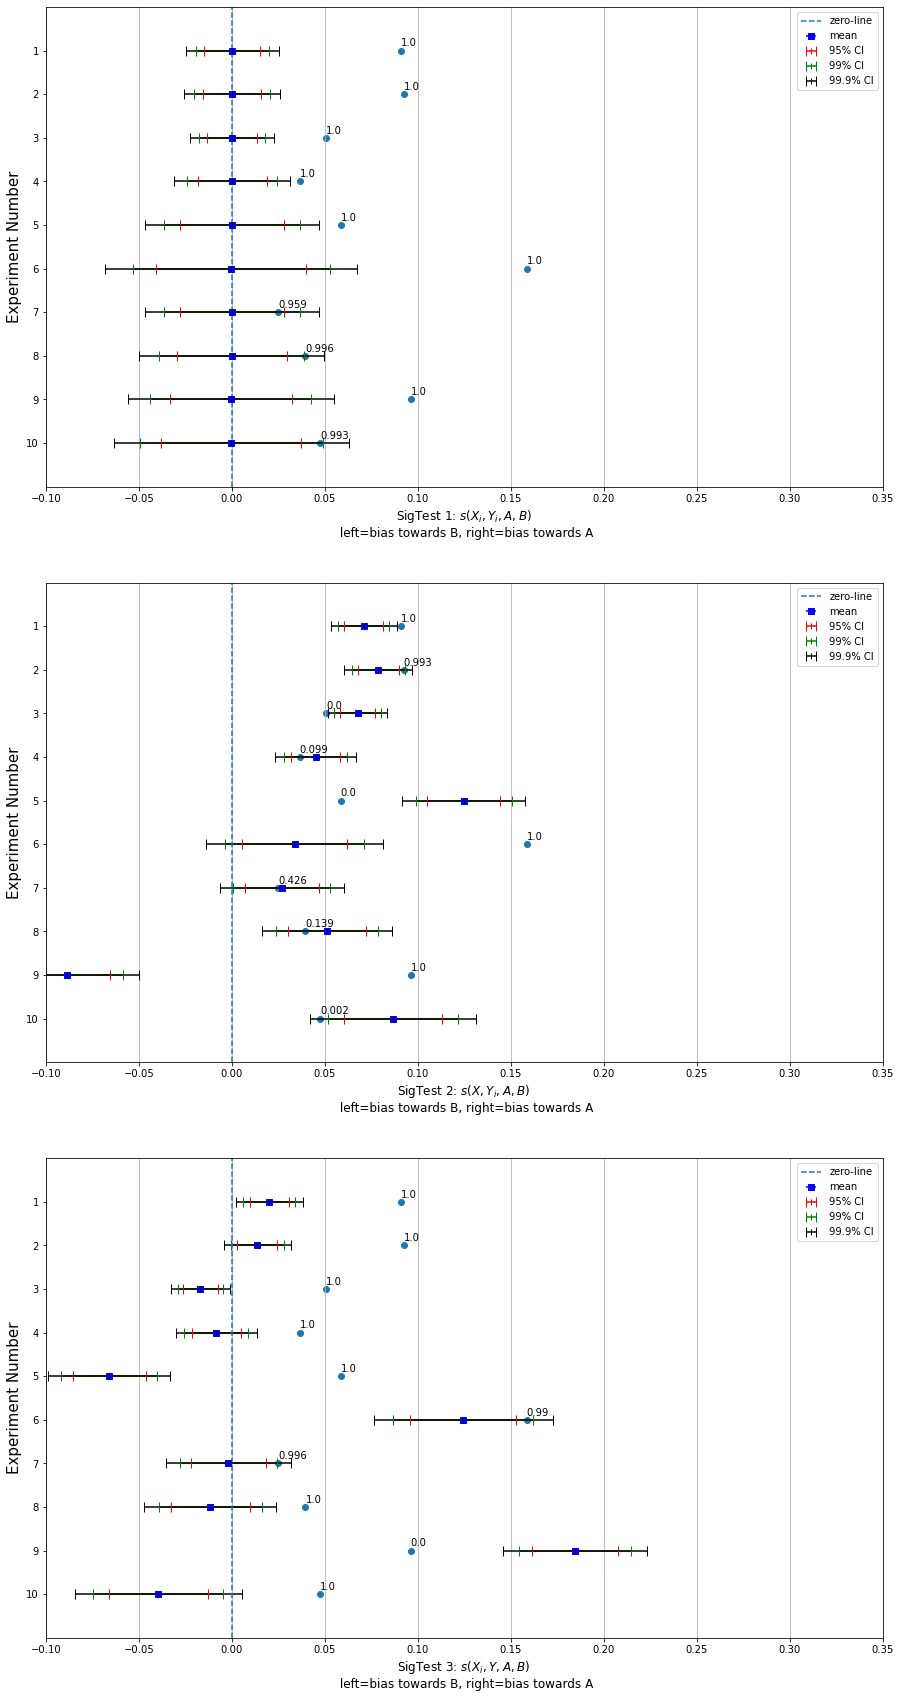

In [24]:
# Whiskers
fig, axs = plt.subplots(3,1, figsize=(15,30))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_AXIS_LIMITS = [11,0]
Y_ANNOTATION_OFFSET = -0.1
exp_nums = [i for i in range(1,11)]

for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    print(f'Means: {means}')
    y = [i for i in range(1,11)]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.95) for exp_num in exp_nums]
    errors_99 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.99) for exp_num in exp_nums]
    errors_999 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.999) for exp_num in exp_nums]
    errors_dict[test_num]['95'] = errors_95
    errors_dict[test_num]['99'] = errors_999
    errors_dict[test_num]['999'] = errors_999
    
    ax.errorbar(means, y, xerr=0, fmt='s', color='b', label='mean')
    ax.errorbar(means, y, xerr=errors_95, fmt='|', color='r', capsize=5, label='95% CI')
    ax.errorbar(means, y, xerr=errors_99, fmt='|', color='g', capsize=5, label='99% CI')
    ax.errorbar(means, y, xerr=errors_999, fmt='|', color='k', capsize=5, label='99.9% CI')
    ax.scatter(test_stats, y)
    dists = [results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums]
    ax.axvline(0, label='zero-line', linestyle='--')
    ax.xaxis.grid()
    #fig.suptitle('Sig Tests', fontsize=20)
    #fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    p_values_dict[test_num] = p_values
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)
    
    ax.set_xlim(X_AXIS_LIMITS)
    ax.set_ylim(Y_AXIS_LIMITS)
    ax.set_yticks(y)
    ax.legend()
plt.savefig(SIGTEST_IMAGE_FILEPATH)

[0.090876885, 0.09231955, 0.050649352, 0.03640392, 0.0583845, 0.15837246, 0.024865322, 0.039520055, 0.096080884, 0.047299553]
[0.090876885, 0.09231955, 0.050649352, 0.03640392, 0.0583845, 0.15837246, 0.024865322, 0.039520055, 0.096080884, 0.047299553]
[0.090876885, 0.09231955, 0.050649352, 0.03640392, 0.0583845, 0.15837246, 0.024865322, 0.039520055, 0.096080884, 0.047299553]


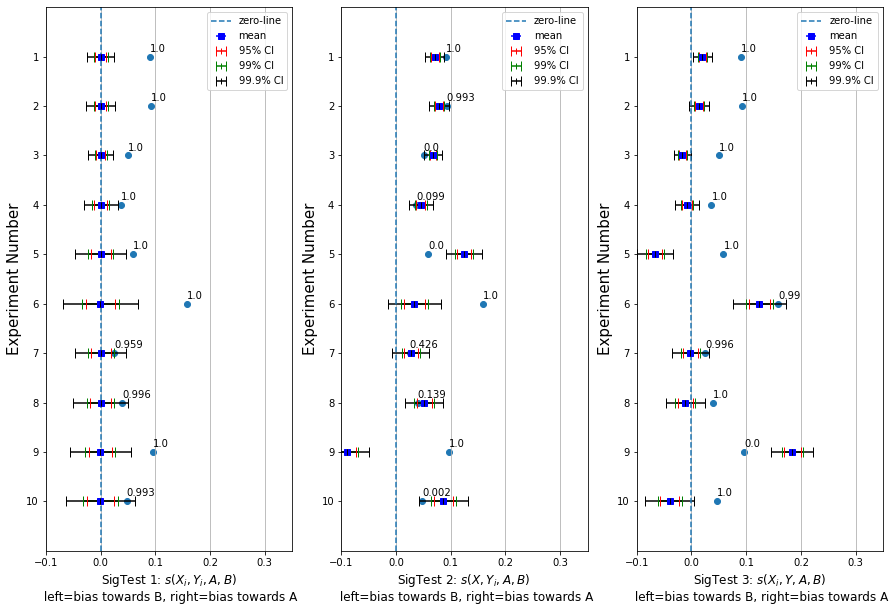

In [25]:
# Whiskers
fig, axs = plt.subplots(1,3, figsize=(15, 10))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_AXIS_LIMITS = [11,0]
Y_ANNOTATION_OFFSET = -0.1
exp_nums = [i for i in range(1,11)]

for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    print(test_stats)
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    y = [i for i in range(1,11)]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.8) for exp_num in exp_nums]
    errors_99 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.9) for exp_num in exp_nums]
    errors_999 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.999) for exp_num in exp_nums]
    
    ax.errorbar(means, y, xerr=0, fmt='s', color='b', label='mean')
    ax.errorbar(means, y, xerr=errors_95, fmt='|', color='r', capsize=5, label='95% CI')
    ax.errorbar(means, y, xerr=errors_99, fmt='|', color='g', capsize=5, label='99% CI')
    ax.errorbar(means, y, xerr=errors_999, fmt='|', color='k', capsize=5, label='99.9% CI')
    ax.scatter(test_stats, y)
    ax.xaxis.grid()
    dists = [results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums]
    ax.axvline(0, label='zero-line', linestyle='--')
    #fig.suptitle('Sig Tests', fontsize=20)
    #fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)
    
    ax.set_xlim(X_AXIS_LIMITS)
    ax.set_yticks(y)
    ax.set_ylim(Y_AXIS_LIMITS)
    ax.legend()
plt.savefig(SIGTEST_HORIZONTAL_IMAGE_FILEPATH)

In [15]:
errors_dict[1]

{'80': [0.009747537526594708,
  0.01008398452298846,
  0.008734318135995942,
  0.01208355557243973,
  0.018214437527616242,
  0.0264047703288639,
  0.018306786329363625,
  0.019357602163923446,
  0.021507493344634233,
  0.02457620580961605],
 '90': [0.014907572198984904,
  0.015422123476801188,
  0.013357986862426638,
  0.018480203500126677,
  0.027856578316934066,
  0.04038261140325844,
  0.027997813621315582,
  0.029604897757057266,
  0.03289287258238769,
  0.03758606329899969],
 '95': [0.014907572198984904,
  0.015422123476801188,
  0.013357986862426638,
  0.018480203500126677,
  0.027856578316934066,
  0.04038261140325844,
  0.027997813621315582,
  0.029604897757057266,
  0.03289287258238769,
  0.03758606329899969]}

In [16]:
p_values_dict[1]

[1.0,
 1.0,
 0.9999999999999464,
 0.9999403366012053,
 0.9999794733547932,
 0.9999999999999934,
 0.9590435763215083,
 0.9956041924957552,
 0.9999999957731447,
 0.9934699107186771]